In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.ticker import FuncFormatter

import seaborn as sns

from pprint import pprint

import math
import subprocess
import re


---

In [2]:
include_small = 0

---

In [3]:
def read_data_comparison(device, sparse_format):
    header = ['matrix','threads','csr_m','csr_n','csr_nnz',
              'time','gflops','csr_mem_footprint','W_avg','J_estimated',
              'format_name','m','n','nnz','mem_footprint',
              'compression_ratio','CSRCV_NUM_PACKET_VALS']
    
    df = pd.read_csv('./' + device + '/' + sparse_format + '.csv', header=None, names=header)
    
    # Modify 'format_name' based on 'sparse_format'
    if 'mkl_ie_f' in sparse_format:
        df['format_name'] = df['format_name'].apply(lambda x: x + '(float)')
    if sparse_format == 'csrrv_d':
        df['format_name'] = df['format_name'].apply(lambda x: 'CSR&RV') 
    
    # need to keep matrix name only (discard full filename + .mtx extension)
    df['matrix'] = df['matrix'].apply(lambda x: x.split('/')[-1].replace('.mtx', ''))
    
    # this column is useless in "normal" formats
    df.drop('CSRCV_NUM_PACKET_VALS', axis=1)
    return df

def read_device_comparison_data(device, sparse_formats):
    # Define a list to hold all DataFrames
    all_dfs = []

    # Iterate through sparse formats and read data
    for sparse_format in sparse_formats:
        df = read_data_comparison(device, sparse_format)
        all_dfs.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(all_dfs, ignore_index=True)

    # Print the merged DataFrame
    return merged_df


In [4]:
sparse_formats = ['aocl_optmv_d', 'csr5_d', 'csr_d', 
                  'csr_vector_lut_x86_d', 'csr_vector_x86_d', 
                  'mkl_ie_d', 'mkl_ie_f', 'sparsex_d']
lumi_comparison_formats_df = read_device_comparison_data('lumi', sparse_formats)
# print('lumi comparison formats\n', sorted(set(lumi_comparison_formats_df['format_name'])))
# lumi_comparison_formats_df

if(include_small):
    sparse_formats = ['/matrices_small/aocl_optmv_d', '/matrices_small/csr5_d', '/matrices_small/csr_d', 
                      '/matrices_small/csr_vector_lut_x86_d', '/matrices_small/csr_vector_x86_d', 
                      '/matrices_small/mkl_ie_d', '/matrices_small/mkl_ie_f', '/matrices_small/sparsex_d']
    lumi_comparison_formats_small_df = read_device_comparison_data('lumi', sparse_formats)
    # lumi_comparison_formats_small_df


In [5]:
sparse_formats = ['aocl_optmv_d', 'csr5_d', 'csr_d', 'csrrv_d', 
                  'csr_vector_lut_x86_d', 'csr_vector_x86_d', 
                  'mkl_ie_d', 'mkl_ie_f', 'sparsex_d']
icy_comparison_formats_df = read_device_comparison_data('icy', sparse_formats)
# print('icy comparison formats\n', sorted(set(icy_comparison_formats_df['format_name'])))
icy_comparison_formats_df

if(include_small):
    sparse_formats = ['/matrices_small/aocl_optmv_d', '/matrices_small/csr5_d', '/matrices_small/csr_d', '/matrices_small/csrrv_d', 
                      '/matrices_small/csr_vector_lut_x86_d', '/matrices_small/csr_vector_x86_d', 
                      '/matrices_small/mkl_ie_d', '/matrices_small/mkl_ie_f', '/matrices_small/sparsex_d']
    icy_comparison_formats_small_df = read_device_comparison_data('icy', sparse_formats)
    # icy_comparison_formats_small_df


---

In [6]:
def read_data_compression(device, sparse_format, tolerance=''):
    header = ['matrix','threads','csr_m','csr_n','csr_nnz',
              'time','gflops','csr_mem_footprint','W_avg','J_estimated',
              'format_name','m','n','nnz','mem_footprint',
              'compression_ratio','CSRCV_NUM_PACKET_VALS',
              'unbalance_time', 'unbalance_size', 'row_bits_avg', 'col_bits_avg', 'row_col_bytes_avg'
             ]
    
    df = pd.read_csv('./' + device + '/' + sparse_format + '.csv', header=None, names=header)
    
    # need to keep matrix name only (discard full filename + .mtx extension)
    df['matrix'] = df['matrix'].apply(lambda x: x.split('/')[-1].replace('.mtx', ''))
    
    if(tolerance!=''):
        df['format_name'] = df['format_name'] + ' (' + df['CSRCV_NUM_PACKET_VALS'].astype(str) + ')' + ' (tolerance 1e-' + tolerance + ')'
    else:
        df['format_name'] = df['format_name'] + ' (' + df['CSRCV_NUM_PACKET_VALS'].astype(str) + ')'
    
    return df

def read_device_compression_data(device, sparse_formats):
    # Define a list to hold all DataFrames
    all_dfs = []

    # Iterate through sparse formats and read data
    for sparse_format in sparse_formats:
        # If an exponential is in the format name, it means that a matrix error tolerance is being checked. 
        # Need to pass the tolerance, in order for the format_name to be formatted accordingly
        tolerance = sparse_format.split('1e-')
        if(len(tolerance)>1):
            df = read_data_compression(device, sparse_format, tolerance[1])
        else:
            df = read_data_compression(device, sparse_format)
        all_dfs.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(all_dfs, ignore_index=True)

    # Print the merged DataFrame
    return merged_df


In [7]:
sparse_formats = [
    'csr_cv_stream_int_sort_abs_znp_shift', 
    'csr_cv_fpc',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-3',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-6',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-7',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-9',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-12'
]
lumi_compression_df = read_device_compression_data('lumi', sparse_formats)
# print('lumi compression formats\n', sorted(set(lumi_compression_df['format_name'])))
lumi_compression_df

if(include_small):
    sparse_formats = ['/matrices_small/csr_cv_stream_int_sort_abs_znp_shift', '/matrices_small/csr_cv_fpc']
    lumi_compression_small_df = read_device_compression_data('lumi', sparse_formats)
    # lumi_compression_small_df    

In [8]:
sparse_formats = ['csr_cv_stream_int_sort_abs_znp_shift', 'csr_cv_fpc']
icy_compression_df = read_device_compression_data('icy', sparse_formats)
# print('icy compression formats\n', sorted(set(icy_compression_df['format_name'])))
icy_compression_df

if(include_small):
    sparse_formats = ['/matrices_small/csr_cv_stream_int_sort_abs_znp_shift', '/matrices_small/csr_cv_fpc']
    icy_compression_small_df = read_device_compression_data('icy', sparse_formats)
    # icy_compression_small_df

---

In [9]:
if(include_small):
    lumi_df = pd.concat([lumi_comparison_formats_df, lumi_compression_df,
                         lumi_comparison_formats_small_df, lumi_compression_small_df,
                        ], ignore_index=True)
else:
    lumi_df = pd.concat([lumi_comparison_formats_df, lumi_compression_df
                        ], ignore_index=True)
# lumi_df

In [10]:
if(include_small):
    icy_df = pd.concat([icy_comparison_formats_df, icy_compression_df,
                        icy_comparison_formats_small_df, icy_compression_small_df,
                       ], ignore_index=True)
else:
    icy_df = pd.concat([icy_comparison_formats_df, icy_compression_df,
                       ], ignore_index=True)
# icy_df

---

In [11]:
# original for IEEE paper
width = 3.487
height = width/1.618

# plt.rc('font', family='serif', serif='Times', size=font)
#plt.rc('text', usetex=True)  
font=5
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 5})
# plt.rc('xtick', labelsize=font)
# plt.rc('ytick', labelsize=font)
# plt.rc('legend', fontsize=font)
# plt.rc('axes', labelsize=font)


In [12]:
# I want to replace the original format names. Do it in tuples (old,new)

def apply_replacements(df, replacements):
    for replacement in replacements:
        old_value, new_value = replacement
        df['format_name'] = df['format_name'].str.replace(old_value, new_value)

# LUMI
replacements =  [('AOCL_OPTMV',            'AMD-AOCL'),
                 ('CSR5',                  'CSR5'),
                 ('Custom_CSR_BV_LUT_x86', 'Dictionary'),
                 ('Custom_CSR_BV_x86',     'Balanced-Vectorized-CSR'),
                 ('Custom_CSR_B',          'Balanced-CSR'),
                 ('MKL_IE(float)',         'MKL(32-bits)'),
                 ('MKL_IE',                'MKL(64-bits)'),
                 ('SparseX',               'SparseX'),
                 ('CSR_CVS',               'HMC'),
                 ('CSR_CV',                'FPC')
                ]
apply_replacements(lumi_df, replacements)

# ICY
replacements =  [('AOCL_OPTMV',            'AMD-AOCL'),
                 ('CSR5',                  'CSR5'),
                 ('Custom_CSR_BV_LUT_x86', 'Dictionary(2)'),
                 ('Custom_CSR_BV_x86',     'Balanced-Vectorized-CSR'),
                 ('Custom_CSR_B',          'Balanced-CSR'),
                 ('CSR&RV',                'Dictionary'),
                 ('MKL_IE(float)',         'MKL(32-bits)'),
                 ('MKL_IE',                'MKL(64-bits)'),
                 ('SparseX',               'SparseX'),
                 ('CSR_CVS',               'HMC'),
                 ('CSR_CV',                'FPC')
                ]
apply_replacements(icy_df, replacements)


---
# Performance of each format for each matrix separately

In [13]:
def plot_barplot_per_matrix(device_df, device, formats_to_plot):
    # Sort matrices by memory footprint (in CSR representation) and then plot each matrix separate
    device_df.sort_values(by='csr_mem_footprint', ascending=True, inplace=True)
    matrix_values = device_df['matrix'].unique()

    # Iterate through each 'matrix' and plot the barplot
    for matrix_value in matrix_values:
        
        # Filter the DataFrame for the specific 'matrix' and the specified formats
        filtered_df = device_df[(device_df['matrix'] == matrix_value) & (device_df['format_name'].isin(formats_to_plot))]

        if filtered_df.empty:
            print(f"No data found for matrix '{matrix_value}' and the specified formats.")
            return

        # Create a custom color palette based on the provided format_color_mapping
        # custom_palette = [format_color_mapping[format_name] for format_name in formats_to_plot]

        # Create the barplot
        sns.barplot(x='format_name', y='gflops', data=filtered_df, order=formats_to_plot)

        plt.title('Performance of Matrix "%s" on device "%s"' % (matrix_value, device))
        plt.xlabel('Format Name')
        plt.ylabel('Performance (GFLOPs)')

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Save the plot as a PDF
        plt.tight_layout()
        plt.savefig('./plots/barplots_per_matrix/'+ device  +'/barplot_matrix_%s.pdf' % (matrix_value))
        plt.close()
        subprocess.run(['pdfcrop', './plots/barplots_per_matrix/'+ device  +'/barplot_matrix_%s.pdf' % (matrix_value)])
        subprocess.run(['mv', './plots/barplots_per_matrix/'+ device  +'/barplot_matrix_%s-crop.pdf' % (matrix_value),
                              './plots/barplots_per_matrix/'+ device  +'/barplot_matrix_%s.pdf' % (matrix_value)])

        
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,height))

normal_formats = ['CSR5', 'SparseX', 'Dictionary', 'MKL(64-bits)', 'MKL(32-bits)', ]

compression_formats = [
                       'FPC (64)',      'FPC (128)',     'FPC (256)',     'FPC (512)', 
                       'FPC (1024)',    'FPC (2048)',    'FPC (4096)',    'FPC (8192)',
                       'FPC (16384)',
                       'FPC (32768)',   'FPC (65536)',   'FPC (131072)',
                       'FPC (262144)',  'FPC (524288)',  'FPC (1048576)', 'FPC (2097152)',
                       'FPC (4194304)', 'FPC (8388608)', 'FPC (16777216)',

                       'HMC (64)',      'HMC (128)',     'HMC (256)',     'HMC (512)', 
                       'HMC (1024)',    'HMC (2048)',    'HMC (4096)',    'HMC (8192)',
                       'HMC (16384)',
                       'HMC (32768)',   'HMC (65536)',   'HMC (131072)',
                       'HMC (262144)',  'HMC (524288)',  'HMC (1048576)', 'HMC (2097152)',
                       'HMC (4194304)', 'HMC (8388608)', 'HMC (16777216)'

                        ]
formats_to_plot = normal_formats + compression_formats

if(0):
    plot_barplot_per_matrix(lumi_df, 'lumi', formats_to_plot)
    plot_barplot_per_matrix(icy_df,  'icy', formats_to_plot)


---

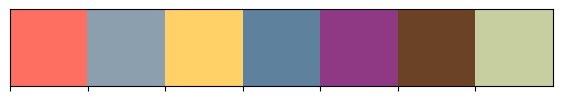

In [14]:
# format_color_mapping = {
#     'FPC (16384)' :  '#f28e2c',
#     'Dictionary'  :  '#76b7b2',
#     'CSR5'        :  '#e15759',
#     'SparseX'     :  '#edc949',
#     'MKL(64-bits)':  '#af7aa1',
#     'MKL(32-bits)':  '#4e79a7',
#     'HMC (16384)' :  '#59a14f'
# }
# sns.palplot(list(format_color_mapping.values()))
# plt.show()


# format_color_mapping = {
#     'FPC (16384)' :  cp6[0],
#     'Dictionary'  :  cp6[1],
#     'CSR5'        :  cp6[2],
#     'SparseX'     :  cp6[3],
#     'MKL(64-bits)':  cp6[4],
#     'MKL(32-bits)':  '#f28e2c',
#     'HMC (16384)' :  '#59a14f'
# }
# sns.palplot(list(format_color_mapping.values()))
# plt.show()

# print('Dirk Gently')
# format_color_mapping = {
#     'FPC (16384)' :  '#FF0000',
#     'Dictionary'  :  '#00FF00', 
#     'CSR5'        :  '#0000FF', 
#     'SparseX'     :  '#FFA500', 
#     'MKL(64-bits)':  '#800080', 
#     'MKL(32-bits)':  '#FFFF00', 
#     'HMC (16384)' :  '#FF1493'
# }
# sns.palplot(list(format_color_mapping.values()))
# plt.show()

# format_color_mapping = {
#     'FPC (16384)' :  '#ff7f00',
#     'Dictionary'  :  '#33a02c',
#     'CSR5'        :  '#e31a1c',
#     'SparseX'     :  '#1f78b4',
#     'MKL(64-bits)':  '#6a3d9a',
#     'MKL(32-bits)':  'yellow', # '#a6cee3',
#     'HMC (16384)' :  'black',  # '#b2df8a'
# }
# sns.palplot(list(format_color_mapping.values()))
# plt.show()

# colors_set1 = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
# sns.palplot(colors_set1)
# plt.show()

# colors_paired = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f']
# sns.palplot(colors_paired)
# plt.show()

# colors_dark2 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d']
# sns.palplot(colors_dark2)
# plt.show()

# colors_set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494']
# sns.palplot(colors_set2)
# plt.show()

# colors_pastel = ['#FFD1DC', '#FFABAB', '#FFC3A0', '#FF677D', '#D4A5A5', '#392F5A', '#31A2AC']
# sns.palplot(colors_pastel)
# plt.show()

# colors_accent = ['#7FC97F', '#BEAED4', '#FDC086', '#FFFF99', '#386CB0', '#F0027F', '#BF5B17']
# sns.palplot(colors_accent)
# plt.show()

# colors_tab10 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2']
# sns.palplot(colors_tab10)
# plt.show()

# wes_anderson_palette = ['#FF6F61', '#FFD166', '#5E819D', '#8F3985', '#6B4226', '#3C6E71', '#D9BF77']
# wes_anderson_palette = ['#FF6F61', '#FFD166', '#5E819D', '#8F3985', '#6B4226', '#3C6E71', '#83AF9B']
wes_anderson_palette = ['#FF6F61', '#8B9FAF', '#FFD166', '#5E819D', '#8F3985', '#6B4226', '#C7CEA0']
sns.palplot(wes_anderson_palette)
plt.show()

---
# Add an "average" and a "geomean" row for each format, which groups all matrices in one measurement

In [15]:
def calc_average(df):
    # Calculate the average gflops for each format_name
    average_gflops = df.groupby('format_name')['gflops'].mean()

    # Create a new DataFrame for the average values
    average_df = pd.DataFrame({'matrix': ['Average'] * len(average_gflops),
                               'format_name': average_gflops.index,
                               'gflops': average_gflops.values,
                               'csr_mem_footprint': [10000] * len(average_gflops)})

    # Append the average information to the original DataFrame
    new_df = pd.concat([df, average_df], ignore_index=True)
    # new_df = new_df[new_df['matrix']=='Average'][['gflops','format_name']]
    # new_df[new_df['format_name'].isin(formats_to_plot)]
    return new_df

def calc_geomean(df):
    # Calculate the geomean gflops for each format_name
    geomean_gflops = df.groupby('format_name')['gflops'].apply(lambda x: np.exp(np.mean(np.log(x))))

    # Create a new DataFrame for the average values
    geomean_df = pd.DataFrame({'matrix': ['Geomean'] * len(geomean_gflops),
                               'format_name': geomean_gflops.index,
                               'gflops': geomean_gflops.values,
                               'csr_mem_footprint': [10000] * len(geomean_gflops)})

    # Append the average information to the original DataFrame
    new_df = pd.concat([df, geomean_df], ignore_index=True)
    # new_df = new_df[new_df['matrix']=='Average'][['gflops','format_name']]
    # new_df[new_df['format_name'].isin(formats_to_plot)]
    return new_df


lumi_df_ext_avg = calc_average(lumi_df)
icy_df_ext_avg  = calc_average(icy_df)

lumi_df_ext_geomean = calc_geomean(lumi_df)
icy_df_ext_geomean  = calc_geomean(icy_df)


In [16]:
def print_per_format(df, device, what, formats):
    print(what + ' performance for "' + device + '"')
    print(df[(df['format_name'].isin(formats)) & (df['matrix']==what)]
          [['format_name','gflops']]
          .sort_values(by='gflops',ascending=True)
          .to_string(index=False),'\n')    

formats = ['FPC (16384)', 'Dictionary', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', 'HMC (16384)']
print_per_format(lumi_df_ext_avg, 'lumi', 'Average', formats)
print_per_format(lumi_df_ext_geomean, 'lumi', 'Geomean', formats)

formats = ['FPC (16384)', 'Dictionary', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', 'HMC (16384)']
print_per_format(icy_df_ext_avg, 'icy', 'Average', formats)
print_per_format(icy_df_ext_geomean, 'icy', 'Geomean', formats)


Average performance for "lumi"
 format_name    gflops
 FPC (16384) 14.099511
  Dictionary 28.164823
        CSR5 29.355174
MKL(64-bits) 30.774565
     SparseX 36.641849
 HMC (16384) 56.761996
MKL(32-bits) 57.373708 

Geomean performance for "lumi"
 format_name    gflops
  Dictionary 10.662100
 FPC (16384) 13.869629
        CSR5 28.944767
MKL(64-bits) 30.269854
     SparseX 35.055934
 HMC (16384) 54.510094
MKL(32-bits) 55.549926 

Average performance for "icy"
 format_name    gflops
 FPC (16384)  3.894652
  Dictionary  7.404106
        CSR5 10.374141
MKL(64-bits) 10.753559
     SparseX 12.230286
 HMC (16384) 14.183824
MKL(32-bits) 17.664558 

Geomean performance for "icy"
 format_name    gflops
 FPC (16384)  3.866490
  Dictionary  5.113651
        CSR5 10.340082
MKL(64-bits) 10.616051
     SparseX 12.028914
 HMC (16384) 13.897067
MKL(32-bits) 17.251679 



---
# Performance of selected formats (including "lossless" method for specific packet size), all matrices in one plot

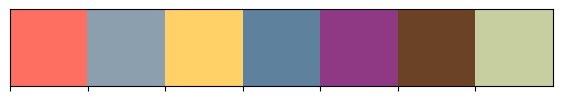

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/performance_comparison_lumi_lossless-crop.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/performance_comparison_icy_lossless-crop.pdf'.


In [17]:
format_color_mapping = {
    'FPC (16384)' :  wes_anderson_palette[0],
    'Dictionary'  :  wes_anderson_palette[1],
    'CSR5'        :  wes_anderson_palette[2],
    'SparseX'     :  wes_anderson_palette[3],
    'MKL(64-bits)':  wes_anderson_palette[4],
    'MKL(32-bits)':  wes_anderson_palette[5],
    'HMC (16384)' :  wes_anderson_palette[6],
}

def plot_barplot_device(device_df, device, formats_to_plot, special=''):
    # Sort matrices by memory footprint (in CSR representation) and then plot each matrix separate
    device_df.sort_values(by='csr_mem_footprint', ascending=True, inplace=True)
    matrix_values = device_df['matrix'].unique()
    
    # Filter the DataFrame for the specified matrices and the specified formats
    filtered_df = device_df[(device_df['matrix'].isin(matrix_values)) & (device_df['format_name'].isin(formats_to_plot))]

    if filtered_df.empty:
        print("No data found for the specified matrices and formats.")
        return

    # Create a mapping of matrix names to IDs
    matrix_id_mapping = {matrix: f'({i+1})' for i, matrix in enumerate(matrix_values)}
    if('Average' in matrix_id_mapping.keys()):
        matrix_id_mapping['Average'] = 'avg'
    if('Geomean' in matrix_id_mapping.keys()):
        matrix_id_mapping['Geomean'] = 'geo\nmean'

    # Replace matrix names with IDs
    filtered_df['matrix_id'] = filtered_df['matrix'].map(matrix_id_mapping)

    # plt.figure(figsize=(24, 16))  # Adjust the figure size as needed
    ax = sns.barplot(x='matrix_id', y='gflops', hue='format_name', data=filtered_df, 
                     palette=format_color_mapping, hue_order=formats_to_plot)

    # plt.title('Performance on device "%s"' % (device))
    plt.xlabel('Matrix ID')
    plt.ylabel('Performance (GFLOPs)')

    # Rotate x-axis labels for better visibility if needed
    plt.xticks(rotation=0)
    
    # Move the legend to the top and display in one line
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=len(formats_to_plot), frameon=False)
    if(len(formats_to_plot)==8):
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(formats_to_plot)//2, frameon=False)
        
    # Save the plot as a PDF
    plt.tight_layout()
    if(include_small):
        extra='_with_small'
    else:
        extra=''
    plt.savefig('./plots/performance_comparison_%s%s%s.pdf' % (device,extra,special))
    plt.close()
    subprocess.run(['pdfcrop', './plots/performance_comparison_%s%s%s.pdf' % (device,extra,special)])
    subprocess.run(['mv', './plots/performance_comparison_%s%s%s-crop.pdf' % (device,extra,special), 
                          './plots/performance_comparison_%s%s%s.pdf' % (device,extra,special)])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(2*width,0.7*height))

# Set the order that formats will be plotted
formats_to_plot = ['FPC (16384)', 'Dictionary', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', 'HMC (16384)']
# plot_barplot_device(lumi_df, 'lumi', formats_to_plot)
# plot_barplot_device(lumi_df_ext_avg, 'lumi', formats_to_plot)
plot_barplot_device(lumi_df_ext_geomean, 'lumi', formats_to_plot, '_lossless')

formats_to_plot = ['Dictionary', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', 'HMC (16384)']
# plot_barplot_device(icy_df,  'icy', formats_to_plot)
# plot_barplot_device(icy_df_ext_avg,  'icy', formats_to_plot)
plot_barplot_device(icy_df_ext_geomean,  'icy', formats_to_plot, '_lossless')


---
# Comparison of different packet sizes for "lossless" method

In [27]:
formats_to_plot = ['HMC (64)', 'HMC (128)', 'HMC (256)', 'HMC (512)', 'HMC (1024)', 'HMC (2048)',
                   'HMC (4096)', 'HMC (8192)', 'HMC (16384)', 'HMC (32768)', 'HMC (65536)', 
                   'HMC (131072)', 'HMC (262144)', 'HMC (524288)', 'HMC (1048576)', 'HMC (2097152)',
                   'HMC (4194304)', 'HMC (8388608)', 'HMC (16777216)']

def convert_to_human_readable(input_number):
    # Convert the input to a numerical value
    try:
        number = float(input_number)
    except ValueError:
        raise ValueError("Input is not a valid number.")

    suffixes = ['', 'K', 'M']
    
    for suffix in suffixes:
        if number >= 1024:
            number /= 1024
        else:
            break

    if number.is_integer():
        return f'{int(number)}{suffix}'
    else:
        return f'{number:.1f}{suffix}'

# Function to extract packet size value from the xtick label
def extract_packet_size(label):
    match = re.search(r'\((.*?)\)', label)
    if match:
        return convert_to_human_readable(match.group(1))
    else:
        return label

def plot_packet_size(df, device, formats_to_plot, plot_type):
    # custom_palette = ['#4E79A7', '#A0CBE8', '#F28E2B', '#FFBE7D', '#8CD17D',
    #                   '#B6992D', '#499894', '#E15759', '#FF9D9A', '#79706E',
    #                   '#D37295', '#FABFD2', '#B07AA1', '#D4A6C8', '#9D7660',
    #                   '#D7B5A6', '#F4B5BD', '#796BAB']
    custom_palette = ['#FF6F61', '#FFD166', '#5E819D', '#8F3985', '#6B4226', '#3C6E71', '#D9BF77', '#D5AB9C', '#7D9EA8', '#7A9D7E', '#A2A18F', '#63774D', '#A8D0DB', '#EAD3C6', '#F0B8A6', '#6C5B7B', '#355C7D', '#ACD8AA', '#FFE156']
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='format_name', y='gflops', data=df, palette=custom_palette,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=formats_to_plot)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='format_name', y='gflops', data=df, palette=custom_palette,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=formats_to_plot)
    
    # Set x-axis labels based on packet size value
    xticks_original = ax.get_xticklabels()
    for xtick in xticks_original:
        xtick.set_text(extract_packet_size(xtick.get_text()))
    ax.set_xticklabels(xticks_original)

    plt.xlabel('Packet Size')
    plt.ylabel('Performance (GFLOPs)')

    # Rotate x-axis labels for better visibility if needed
    plt.xticks(rotation=30)
    
    if(include_small):
        extra='_with_small'
    else:
        extra=''

    # Save the plot as a PDF
    plt.tight_layout()
    plt.savefig('./plots/packet_size_perf_' + device + '_' + plot_type + extra + '.pdf')
    plt.close()
    subprocess.run(['pdfcrop', './plots/packet_size_perf_' + device + '_' + plot_type + extra + '.pdf'])
    subprocess.run(['mv', './plots/packet_size_perf_' + device + '_' + plot_type + extra + '-crop.pdf', 
                          './plots/packet_size_perf_' + device + '_' + plot_type + extra + '.pdf'])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,0.8*height))

plot_packet_size(lumi_df, 'lumi', formats_to_plot, plot_type = 'box')
plot_packet_size(icy_df, 'icy', formats_to_plot, plot_type = 'box')


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/packet_size_perf_lumi_box-crop.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/packet_size_perf_icy_box-crop.pdf'.


---
---
# Performance and Errors (matrix and spmv) of "lossy" methods
## we have collected measurements for different matrix error tolerance for 3, 6, 7, 9, 12 bits on lumi

In [28]:
# Function to convert float to scientific notation
def float_to_scientific(x):
    if(x==0):
        return 0.0000e-12
    else:
        return '{:.4e}'.format(x)

# Function to extract the exponent from a scientific notation string
def extract_exponent(sci_notation):
    # Split the string at 'e' to get the exponent part
    parts = str(sci_notation).split('e')
    if len(parts) == 2:
        return math.log10(float(sci_notation))
    else:
        return -12

def error_parsing(sparse_format):
    # if not lossy format tested (mkl-32) no need to use extra in filename of awk
    # else use the specific awk file, that filters only '16384' packet size values
    extra=''
    if('e-' in sparse_format):
        extra = '_16384'

    # thanks dgal for the awk magic!!
    output = subprocess.check_output(['awk', '-f', 'parse_cv_errors'+extra+'.awk', sparse_format + '.out'])
    output_lines = output.decode('utf-8').split('\n')

    # Remove the last empty line if exists
    if output_lines[-1] == '':
        output_lines.pop()

    # Convert the output to a DataFrame    
    # awk returns errors separated by \t, need to parse it and pass it to a pandas dataframe
    header_names = ['Matrix MAE','Matrix max AE','Matrix MSE','Matrix MAPE','Matrix SMAPE',
                    'SpMV MAE',  'SpMV max AE',  'SpMV MSE',  'SpMV MAPE',  'SpMV SMAPE']
    
    error_df = pd.DataFrame([line.split('\t') for line in output_lines], columns=header_names)
    error_df[header_names] = error_df[header_names].astype(float)
    
    header_names = ['Matrix SMAPE', 'SpMV SMAPE']
    # Need to extract exponent in order to plot violin plot with exponents only 
    # (if using log scale on y axis it, everything is messed up)
    for variable in header_names:
        error_df[variable + ' scientific'] = error_df[variable].apply(float_to_scientific)
        error_df[variable + ' exponent'] = error_df[variable+ ' scientific'].apply(extract_exponent)
    matrix_error_tolerance = sparse_format.split('1e-')
    if(len(matrix_error_tolerance) > 1):
        error_df['Matrix Error Tolerance'] = '1e-'+matrix_error_tolerance[1]
    else:
        error_df['Matrix Error Tolerance'] = 'MKL(32-bits)'
    return error_df

# files that contain 
prefix='./lumi/sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-'
sparse_formats = [prefix+'12', prefix+'9', prefix+'7', prefix+'6', prefix+'3', 
                  './lumi/mkl_ie_f']
all_dfs = []
for sparse_format in sparse_formats:
    all_dfs.append(error_parsing(sparse_format))

matrix_and_spmv_error = pd.concat(all_dfs)
matrix_and_spmv_error

,Matrix MAE,Matrix max AE,Matrix MSE,Matrix MAPE,Matrix SMAPE,SpMV MAE,SpMV max AE,SpMV MSE,SpMV MAPE,SpMV SMAPE,Matrix SMAPE scientific,Matrix SMAPE exponent,SpMV SMAPE scientific,SpMV SMAPE exponent,Matrix Error Tolerance
0,2.579310e-17,1.952920e-16,2.466500e-33,0.000000e+00,0.000000e+00,9.695510e-14,8.031350e-13,2.188800e-26,1.288830e-11,6.444170e-12,0.0,-12.000000,6.4442e-12,-11.190831,1e-12
1,4.561390e-08,4.250560e-05,9.022330e-14,4.563450e-11,2.281730e-11,5.358190e-07,9.736420e-05,5.966370e-12,2.562030e-08,1.281020e-08,2.2817e-11,-10.641741,1.2810e-08,-7.892451,1e-12
2,1.343950e-13,4.524030e-11,3.343150e-25,2.689730e-11,1.344860e-11,1.151740e-12,5.127990e-11,7.350600e-24,3.267580e-10,1.633790e-10,1.3449e-11,-10.871310,1.6338e-10,-9.786801,1e-12
3,1.141860e+04,2.237730e+08,4.032810e+11,1.837550e-11,9.187750e-12,9.996200e+04,1.329900e+08,3.160070e+12,1.502620e+05,2.627970e-02,9.1877e-12,-11.036793,2.6280e-02,-1.580375,1e-12
4,8.066000e-09,5.710170e-07,9.790520e-16,4.676180e-11,2.338090e-11,5.796890e-08,4.574390e-07,7.896460e-15,1.069830e+01,7.339580e-04,2.3381e-11,-10.631137,7.3396e-04,-3.134328,1e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,2.150000e-09,4.700000e-07,3.550000e-16,3.700000e-08,1.850000e-08,1.039800e-06,8.583070e-06,3.169260e-12,1.697140e-05,8.485710e-06,1.8500e-08,-7.732828,8.4857e-06,-5.071312,MKL(32-bits)
25,9.410000e-08,1.910000e-03,6.530000e-12,1.860000e-06,9.290000e-07,1.356450e-05,1.228170e-02,6.507190e-09,2.027590e-02,8.418380e-03,9.2900e-07,-6.031984,8.4184e-03,-2.074770,MKL(32-bits)
26,2.290000e+04,2.140000e+09,1.950000e+12,2.060000e-06,1.030000e-06,9.224060e+05,5.368710e+09,4.490640e+14,inf,6.315020e+01,1.0300e-06,-5.987163,6.3150e+01,1.800373,MKL(32-bits)
27,2.220000e-09,2.980000e-08,1.850000e-17,2.110000e-06,1.050000e-06,4.171630e-08,3.040700e-06,5.534410e-15,inf,2.344430e+01,1.0500e-06,-5.978811,2.3444e+01,1.370032,MKL(32-bits)


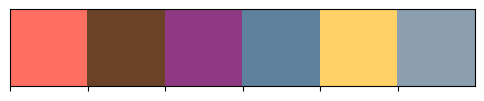

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/lossy_Matrix_SMAPE_exponent_violin-crop.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/lossy_SpMV_SMAPE_exponent_violin-crop.pdf'.


In [29]:
format_color_mapping = {
    'MKL(32-bits)': wes_anderson_palette[0],
    '1e-3' :  wes_anderson_palette[5],
    '1e-6' :  wes_anderson_palette[4],
    '1e-7' :  wes_anderson_palette[3],
    '1e-9' :  wes_anderson_palette[2], 
    '1e-12' : wes_anderson_palette[1],
}

# Function to format y-axis labels as integers
def format_y_axis_ticks(value, _):
    return f'{int(value):d}'

def plot_lossy_error(df, variable, plot_type):
    # Get unique values of 'Matrix Error Tolerance' and reverse the order
    # unique_error_tolerances = df['Matrix Error Tolerance'].unique()[::-1]
    unique_error_tolerances = ['MKL(32-bits)', '1e-12', '1e-9', '1e-7', '1e-6', '1e-3']
    
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='Matrix Error Tolerance', y=variable, data=df, palette=format_color_mapping,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='Matrix Error Tolerance', y=variable, data=df, palette=format_color_mapping,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    
    plt.xlabel('Matrix Error Tolerance')
    plt.ylabel(variable)
    
    ax.xaxis.set_label_coords(0.58, -0.15)  # Adjust the y-coordinate as needed
    
    plt.annotate('|________________________________________________________________|', 
                 xy=(2.98, -0.13), xycoords=ax.get_xaxis_transform(), ha='center', fontsize=5)
    
    if('exponent' not in variable):
        plt.yscale('log')  # Set y-axis scale to log (only when printing boxplot)
    else:
        # Set the y-axis labels to display as integers
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis_ticks))

    # Save the plot as a PDF
    plt.tight_layout()
    plt.savefig('./plots/lossy_'+variable.replace(' ','_') + '_' + plot_type + '.pdf')
    plt.close()
    subprocess.run(['pdfcrop', './plots/lossy_'+variable.replace(' ','_') + '_' + plot_type + '.pdf'])
    subprocess.run(['mv', './plots/lossy_'+variable.replace(' ','_') + '_' + plot_type + '-crop.pdf', 
                          './plots/lossy_'+variable.replace(' ','_') + '_' + plot_type + '.pdf'])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,0.8*height))

# header_names = ['Matrix MAE','Matrix max AE','Matrix MSE','Matrix MAPE','Matrix SMAPE',
#                 'SpMV MAE',  'SpMV max AE',  'SpMV MSE',  'SpMV MAPE',  'SpMV SMAPE']
header_names = ['Matrix SMAPE', 'SpMV SMAPE']
for variable in header_names:
    # plot_lossy_error(matrix_and_spmv_error, variable, plot_type = 'box')
    plot_lossy_error(matrix_and_spmv_error, variable + ' exponent', plot_type = 'violin')


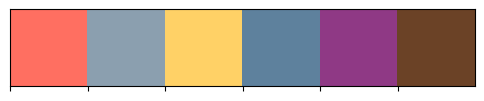

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/lossy_gflops_lumi_box-crop.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/lossy_compression_ratio_lumi_box-crop.pdf'.


In [43]:
format_color_mapping = {
    'MKL(32-bits)':  wes_anderson_palette[0],
    'HMC (16384) (tolerance 1e-12)' : wes_anderson_palette[1],
    'HMC (16384) (tolerance 1e-9)' :  wes_anderson_palette[2], 
    'HMC (16384) (tolerance 1e-7)' :  wes_anderson_palette[3],
    'HMC (16384) (tolerance 1e-6)' :  wes_anderson_palette[4],
    'HMC (16384) (tolerance 1e-3)' :  wes_anderson_palette[5],
}

# Function to extract tolerance value from the xtick label
def extract_tolerance(label):
    match = re.search(r'\(tolerance (.*?)\)', label)
    if match:
        return match.group(1)
    else:
        return label

# Function to format y-axis labels as integers
def format_y_axis_ticks(value, _):
    return f'{int(value):d}'

def plot_lossy_perf(df, device, variable, plot_type):
    # Get unique values of 'Matrix Error Tolerance' and reverse the order
    # unique_error_tolerances = df['Matrix Error Tolerance'].unique()[::-1]
    unique_error_tolerances = format_color_mapping.keys()
    
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='format_name', y=variable, data=df, palette=format_color_mapping,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='format_name', y=variable, data=df, palette=format_color_mapping,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    
    # Set x-axis labels based on tolerance value
    xticks_original = ax.get_xticklabels()
    for xtick in xticks_original:
        xtick.set_text(extract_tolerance(xtick.get_text()))
    ax.set_xticklabels(xticks_original)

    plt.xlabel('Matrix Error Tolerance')
    if(variable == 'compression_ratio'):
        plt.ylabel('Ratio of original footprint after compression')
    if(variable == 'gflops'):
        plt.ylabel('Performance (GFLOPs)')

    ax.xaxis.set_label_coords(0.58, -0.15)  # Adjust the y-coordinate as needed
    
    plt.annotate('|________________________________________________________________|', 
                 xy=(2.98, -0.12), xycoords=ax.get_xaxis_transform(), ha='center', fontsize=5)
    
    # Set the y-axis labels to display as integers
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis_ticks))

    if(include_small):
        extra='_with_small'
    else:
        extra=''

    # Save the plot as a PDF
    plt.tight_layout()
    plt.savefig('./plots/lossy_'+variable.replace(' ','_') + '_'+ device + '_' + plot_type + extra + '.pdf')
    plt.close()
    subprocess.run(['pdfcrop', './plots/lossy_'+variable.replace(' ','_') + '_'+ device + '_' + plot_type + extra + '.pdf'])
    subprocess.run(['mv', './plots/lossy_'+variable.replace(' ','_') + '_'+ device + '_' + plot_type + extra + '-crop.pdf', 
                          './plots/lossy_'+variable.replace(' ','_') + '_'+ device + '_' + plot_type + extra + '.pdf'])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,0.8*height))

header_names = ['gflops', 'compression_ratio']
for variable in header_names:
    plot_lossy_perf(lumi_df, 'lumi', variable, plot_type = 'box')
    # plot_lossy_perf(lumi_df, 'lumi', variable, plot_type = 'violin')


# Performance of lossy methods, along with MKL and lossless (per matrix)

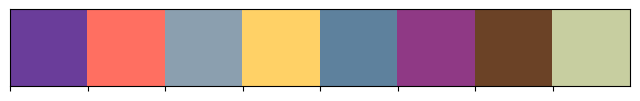

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./plots/performance_comparison_lumi_lossy-crop.pdf'.


In [32]:
format_color_mapping = {
    'MKL(64-bits)':  '#6a3d9a',
    'MKL(32-bits)':  wes_anderson_palette[0],
    'HMC (16384)' :  wes_anderson_palette[1],
    'HMC (16384) (tolerance 1e-12)' : wes_anderson_palette[2],
    'HMC (16384) (tolerance 1e-9)' :  wes_anderson_palette[3],
    'HMC (16384) (tolerance 1e-7)' :  wes_anderson_palette[4],
    'HMC (16384) (tolerance 1e-6)' :  wes_anderson_palette[5],
    'HMC (16384) (tolerance 1e-3)' :  wes_anderson_palette[6],
}

plt.rc('figure', figsize=(2*width,0.7*height))

# Set the order that formats will be plotted
formats_to_plot = ['MKL(64-bits)', 'MKL(32-bits)', 'HMC (16384)', 'HMC (16384) (tolerance 1e-12)', 
                   'HMC (16384) (tolerance 1e-9)', 'HMC (16384) (tolerance 1e-7)', 
                   'HMC (16384) (tolerance 1e-6)', 'HMC (16384) (tolerance 1e-3)']
plot_barplot_device(lumi_df, 'lumi', formats_to_plot, '_lossy')


---
# panastas magic

In [ ]:
# For Petros magic in paper
filter_df = lumi_df[lumi_df['format_name'] == 'HMC (16384)'][['matrix','mem_footprint', 'csr_mem_footprint', 'compression_ratio']]
filter_df.sort_values(by='csr_mem_footprint', ascending=True, inplace=True)
filter_df.to_csv('./plots/compression_16384.csv', index=False)
filter_df

In [ ]:
matrices_str = "bone010\tboneS10\tcage15\tnlpkkt120\tnlpkkt160\tnlpkkt200\tcircuit5M\tFlan_1565\tvas_stokes_2M\tspal_004\tvas_stokes_4M\tstokes\taf_shell10\tHook_1498\tnv2\tCube_Coup_dt0\tCube_Coup_dt6\tldoor\tdielFilterV2real\tGeo_1438\tSerena\tLong_Coup_dt0\tLong_Coup_dt6\taudikw_1\tdielFilterV3real\tBump_2911\tML_Geer\tQueen_4147\tHV15R"
matrix_names = matrices_str.replace('_','\_').split("\t")
#matrix_names
matrices_sz_str = "823.919979\t638.275776\t1154.912998\t1121.825321\t2658.462284\t5191.485966\t702.404785\t1349.574764\t753.531605\t528.391174\t1522.503262\t4041.349312\t608.539738\t702.859341\t608.974438\t1464.016697\t1464.016697\t536.039845\t559.89957\t728.256344\t743.814289\t1002.262608\t1002.262608\t892.25478\t1026.233234\t1472.858875\t1274.657894\t3786.640026\t3247.213531"
matrixes_sz = list(map(lambda x: np.double(x), matrices_sz_str.split("\t")))
#matrixes_sz
matrices_uv_str = "5.30E-07\t7.21E-07\t5.44E-06\t2.07E-05\t1.62E-05\t1.24E-05\t0.000718295\t0.00647238\t0.0226447\t0.0612745\t0.0377353\t0.0310682\t0.206748\t0.193697\t0.256889\t0.148341\t0.148405\t0.465906\t0.511923\t0.464047\t0.507285\t0.413868\t0.413869\t0.476789\t0.505379\t0.507364\t0.989451\t0.477945\t0.835282"
matrices_uv = list(map(lambda x: np.double(x), matrices_uv_str.split("\t")))
#matrices_uv

merge_df = pd.DataFrame(
    {'Name': matrix_names,
     'Size': matrixes_sz,
     'UV': matrices_uv
    }).sort_values('Size')

matrices_szc_str = "240.874468,420.32475,491.77146,414.252256,428.153537,212.984193,314.330976,431.186882,462.534705,491.143406,415.798345,274.985479,651.625595,612.395664,613.908869,910.79281,464.078259,480.486862,893.000404,529.35609,685.467156,691.248268,863.741854,869.577411,1099.317433,2833.181491,2408.419473,2428.59264,2146.266891"
matrices_szc = list(map(lambda x: np.double(x), matrices_szc_str.split(","))) 
merge_df['Size_comp'] = matrices_szc
merge_df['Size_perc'] = merge_df['Size_comp']/ merge_df['Size']
id = 1
for idx,elem in merge_df.iterrows():
    if (100*elem[2] < 0.1):
        print("%d & %s & %.2e & %.2lf \\\\" %(id, elem[0], 100*elem[2], 100*elem[4]))
    else:
        print("%d & %s & %.2lf & %.2lf \\\\" %(id, elem[0], 100*elem[2], 100*elem[4]))
    id+=1